# Importing the usual stuff 

In [18]:
import torch
import torchvision
import torch.nn as nn                                              
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

import numpy as np
np.set_printoptions(threshold=50)    # 50 lines 
from scipy.ndimage.filters import gaussian_filter1d   ## smoothe

# Load up the test set
> Also set the batch size to 1 for checking on individual elements 

In [3]:
labels = np.array(np.load("numpy/labels.npy"))
x_test = np.array(np.load("numpy/x_test.npy"))
y_test = np.array(np.load("numpy/y_test.npy"))

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)       ## make compatible with DataLoader 

val_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle = True)

print(len(val_loader), "iterations")


12630 iterations


### Building the NN again
> Simple workaround for `torch.load()` to work without errors 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 45, 3)           
        
        self.pool = nn.MaxPool2d(3,3)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(45,90,3)
        self.conv3 = nn.Conv2d(90,150,3) 
        
        self.conv4 = nn.Conv2d(150,200,3)

        self.fc1 = nn.Linear(3200, 1200)   # linear layers   
        self.fc2 = nn.Linear(1200, 430)
        
        self.fc3 = nn.Linear(430, 43)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
                                                                       
        x = self.dropout(self.pool(x))
 
        x = F.relu(self.conv2(x))
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
    
        x = x.view(x.size(0), -1)        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x =F.relu(self.fc2(x))
        x = self.fc3(x)
   
        return x

trafficnet = Net()
print(trafficnet)
net = trafficnet

Net(
  (conv1): Conv2d(3, 45, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(45, 90, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=430, bias=True)
  (fc3): Linear(in_features=430, out_features=43, bias=True)
)


### Utilities 
>`preprocess()` takes in raw image path and returns a torch.FloatTensor() ready to be fed to the NN <br>
> `image_path_to_result()` pretty self explanatory, image gets fed to NN and the result is returned 

In [4]:
def preprocess(img_path, show = False):
    
    im = Image.open(img_path)
    im = im.resize((32, 32))
    np_im = np.array(im)
    if show == True:
        
        plt.imshow(np_im)
        plt.show()
    np_im = np.moveaxis(np_im, 2,0)
    inp = torch.from_numpy(np_im).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    
    return inp 

def image_path_to_result(img_path):
    
    model = torch.load("torch/checker.pth")
    
    im_tensor = preprocess(img_path, show = True)

    res = model(im_tensor).squeeze(0)
    
    arg = res.max(0)[1].item()
    
    print(labels[arg])

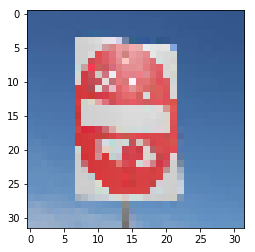

No entry


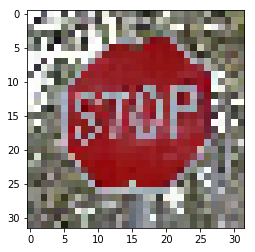

Stop


In [19]:
image_path_to_result("i.jpeg")  ##  check on a googled image because why not 
image_path_to_result("s.jpg")  ##  check on a googled image because why not 



## Benchmarking
> Calculates accuracy of the NN, simple stuff <br>
> Got 91% in the last checkpoint, not too bad I guess 

In [13]:
def benchmark_trafficnet(  model_path, total):
 
    model = torch.load(model_path)
    print ("benchmarking ...")
    
    with torch.no_grad():    
        acc = 0         
        correct = 0
        for x_val, y_val in val_loader:

            model.eval()

            y_val = y_val.long()

            yhat = model(x_val)  # pred 
            val_loss = F.cross_entropy(yhat, y_val)
  
            alpha = yhat.squeeze(0)
            
            alpha = alpha.max(0)[1].item()  # predicted index 
            
            beta = y_val.item()
            
            if alpha == beta :
                correct += 1
         
        acc = (correct/total)*100
        
        clear_output()

        print("acc = ", acc, " %")      

In [254]:
benchmark_trafficnet("torch/epsilon.pth", len(val_loader))

acc =  89.95249406175772  %


In [16]:
benchmark_trafficnet("torch/checker.pth", len(val_loader))

acc =  91.04513064133016  %
